# 歩行者回避行動予測MLP
## 概要
- 歩行者が周囲の他者を避けながら30フレーム後（0.5秒後）にどこに移動するかを予測
- 入力: 自己速度(1) + 近傍5人の相対位置・速度・validフラグ(25) = 26変数
- 出力: 自己座標系での30フレーム後変位 Δx・Δy (2変数)
- 測地系をEPSG:3857→EPSG:6677に変更、制度の改善が見込める

仮想環境の作成

jupyter lab --no-browser --ip 127.0.0.1 --port 8888

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ディレクトリの指定
os.chdir("/mnt/f/grad_thesis/tracking/st_nn11")

# パラメータ設定
FPS = 60  # フレームレート
FRAME_INTERVAL = 30  # 予測間隔（フレーム数）
PREDICTION_TIME = FRAME_INTERVAL / FPS  # 予測時間間隔（秒）
MAX_NEIGHBORS = 5  # 考慮する近傍歩行者数
SEARCH_RADIUS = 5.0  # 近傍探索半径（メートル）

print("ディレクトリ:", os.getcwd())
print(f"予測間隔: {FRAME_INTERVAL}フレーム ({PREDICTION_TIME:.2f}秒)")

ディレクトリ: /mnt/f/grad_thesis/tracking/st_nn11
予測間隔: 30フレーム (0.50秒)


## 1. データ読み込みと前処理

In [3]:
# 移動平均処理済みデータを読み込み
gdf = gpd.read_file("MAtraj.gpkg")
print(f"データ数: {len(gdf)}")
print(f"歩行者数: {gdf['uid'].nunique()}")
print(f"フレーム範囲: {gdf['Frame'].min()} - {gdf['Frame'].max()}")
print("\nデータ構造:")
print(gdf.head())

データ数: 326728
歩行者数: 1254
フレーム範囲: 0 - 19029

データ構造:
   Frame  uid    lat_raw   lon_raw  alt                         datetime  \
0     72    4  35.689572  139.7018  NaN 2025-01-01 00:00:01.200000+09:00   
1     73    4  35.689572  139.7018  NaN 2025-01-01 00:00:01.217000+09:00   
2     74    4  35.689573  139.7018  NaN 2025-01-01 00:00:01.233000+09:00   
3     75    4  35.689573  139.7018  NaN 2025-01-01 00:00:01.250000+09:00   
4     76    4  35.689573  139.7018  NaN 2025-01-01 00:00:01.267000+09:00   

         lat         lng                          geometry  
0  35.689576  139.701803  POINT (15551533.601 4257991.206)  
1  35.689576  139.701803  POINT (15551533.601 4257991.206)  
2  35.689576  139.701803  POINT (15551533.601 4257991.206)  
3  35.689576  139.701803  POINT (15551533.601 4257991.206)  
4  35.689576  139.701803  POINT (15551533.601 4257991.206)  


In [4]:
# 座標をメートル単位に変換（日本測地系2011第Ⅸ系 EPSG:6677）
if gdf.crs != 'EPSG:6677':
    gdf = gdf.to_crs('EPSG:6677')

# x, y座標を抽出
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# フレーム順にソート
gdf = gdf.sort_values(['uid', 'Frame']).reset_index(drop=True)
print("座標変換完了")

座標変換完了


## 2. 速度・ヘディング計算（30フレーム間隔）

In [5]:
def calculate_velocity_and_heading(df):
    """速度とヘディング角度を計算（FRAME_INTERVAL間隔で）"""
    result_list = []
    
    # uidごとにグループ化して処理を高速化
    for uid, person_data in df.groupby('uid'):
        person_data = person_data.copy().sort_values('Frame')
        
        if len(person_data) < FRAME_INTERVAL + 1:
            continue
            
        # FRAME_INTERVAL間隔での速度計算
        #person_data['vx'] = (person_data['x'].shift(-FRAME_INTERVAL) - person_data['x']) / PREDICTION_TIME  #前方差分
        #person_data['vy'] = (person_data['y'].shift(-FRAME_INTERVAL) - person_data['y']) / PREDICTION_TIME
        person_data['vx'] = (person_data['x'] - person_data['x'].shift(FRAME_INTERVAL)) / PREDICTION_TIME #後方差分
        person_data['vy'] = (person_data['y'] - person_data['y'].shift(FRAME_INTERVAL)) / PREDICTION_TIME

        person_data['speed'] = np.sqrt(person_data['vx']**2 + person_data['vy']**2)
        
        # ヘディング角度計算（進行方向）
        person_data['heading'] = np.arctan2(person_data['vy'], person_data['vx'])
        
        # NaN値を除去（最後のFRAME_INTERVAL分は計算できないため）
        person_data = person_data.dropna(subset=['vx', 'vy', 'heading'])
        
        if len(person_data) > 0:
            result_list.append(person_data)
    
    if not result_list:
        return pd.DataFrame()
        
    # uid列を保持したまま結合
    return pd.concat(result_list, ignore_index=False)

# 速度・ヘディング計算実行
processed_data = calculate_velocity_and_heading(gdf)
print(f"処理後データ数: {len(processed_data)}")
if 'uid' in processed_data.columns and not processed_data.empty:
    print(f"有効歩行者数: {processed_data['uid'].nunique()}")
    print(f"平均速度: {processed_data['speed'].mean():.2f} m/s")
else:
    print("エラー: 'uid'列が見つからないか、処理後のデータが空です。")

処理後データ数: 294778
有効歩行者数: 921
平均速度: 0.74 m/s


## 3. 近傍歩行者探索と特徴量作成（30フレーム後予測）

In [6]:
def create_training_data(df):
    """教師データ作成（30フレーム後の位置を予測）+ 過去0.5/1/2秒の相対位置（現在ego基準）を追加"""
    features = []
    targets = []
    uids = []  # uidを保持するリスト

    PAST_OFFSETS = [FRAME_INTERVAL, 2 * FRAME_INTERVAL, 4 * FRAME_INTERVAL]  # 0.5s, 1s, 2s 分

    # フレームごとに処理
    for frame in df['Frame'].unique():
        frame_data = df[df['Frame'] == frame].copy()
        # 30フレーム後のデータを取得
        future_frame_data = df[df['Frame'] == frame + FRAME_INTERVAL].copy()

        # 処理に必要な最小人数（自分＋他人）を確認
        if len(frame_data) < 2 or len(future_frame_data) == 0:
            continue

        # KDTreeで近傍探索（現在フレーム）
        positions = frame_data[['x', 'y']].values
        tree = KDTree(positions)

        for idx, person in frame_data.iterrows():
            # 30フレーム後での位置を取得
            future_pos = future_frame_data[future_frame_data['uid'] == person['uid']]
            if len(future_pos) == 0:
                continue

            future_pos = future_pos.iloc[0]

            # 自己座標系での30フレーム後変位（回転は現在tのheading）
            cos_h = np.cos(person['heading'])
            sin_h = np.sin(person['heading'])
            dx_world = future_pos['x'] - person['x']
            dy_world = future_pos['y'] - person['y']
            dx_ego = dx_world * cos_h + dy_world * sin_h
            dy_ego = -dx_world * sin_h + dy_world * cos_h

            # kの値を動的に調整
            n_points_in_frame = len(positions)
            k_neighbors = min(MAX_NEIGHBORS + 1, n_points_in_frame)

            # 近傍探索（自分を除く）
            distances, indices = tree.query([person[['x', 'y']].values],
                                            k=k_neighbors,
                                            return_distance=True)

            # 特徴量ベクトル作成（現行：自己速度 + 近傍の相対位置/相対速度/valid）
            feature_vector = [person['speed']]  # 自己速度

            neighbor_uids = []  # 選定した近傍のuid（順序固定）
            neighbor_count = 0
            for i in range(1, len(indices[0])):  # 自分（index=0）を除く
                if distances[0][i] > SEARCH_RADIUS:
                    break

                neighbor_idx = indices[0][i]
                neighbor = frame_data.iloc[neighbor_idx]
                neighbor_uids.append(neighbor['uid'])

                # 相対位置（自己座標系, 基準=現在t）
                rel_x_world = neighbor['x'] - person['x']
                rel_y_world = neighbor['y'] - person['y']
                rel_x_ego = rel_x_world * cos_h + rel_y_world * sin_h
                rel_y_ego = -rel_x_world * sin_h + rel_y_world * cos_h

                # 相対速度（自己座標系, 相手−自分）
                rel_vx_world = neighbor['vx'] - person['vx']
                rel_vy_world = neighbor['vy'] - person['vy']
                rel_vx_ego = rel_vx_world * cos_h + rel_vy_world * sin_h
                rel_vy_ego = -rel_vx_world * sin_h + rel_vy_world * cos_h

                feature_vector.extend([rel_x_ego, rel_y_ego, rel_vx_ego, rel_vy_ego, 1.0])  # valid=1
                neighbor_count += 1
                if neighbor_count >= MAX_NEIGHBORS:
                    break

            # 不足分をゼロパディング（現在フレームの近傍スロット）
            while neighbor_count < MAX_NEIGHBORS:
                feature_vector.extend([0.0, 0.0, 0.0, 0.0, 0.0])  # dx, dy, dvx, dvy, valid=0
                neighbor_uids.append(None)  # 後続の過去参照用にプレースホルダも追加
                neighbor_count += 1

            # ========= ここから拡張：過去0.5/1/2秒の相対位置（現在ego基準）を追加 =========
            # 自己（各時点：x,y,valid）
            for off in PAST_OFFSETS:
                past_frame_num = frame - off
                past_frame_data = df[df['Frame'] == past_frame_num]

                if len(past_frame_data) > 0:
                    self_past = past_frame_data[past_frame_data['uid'] == person['uid']]
                else:
                    self_past = None

                if self_past is not None and len(self_past) > 0:
                    sp = self_past.iloc[0]
                    rel_x_world = sp['x'] - person['x']  # 原点は現在の自己位置
                    rel_y_world = sp['y'] - person['y']
                    rel_x_ego = rel_x_world * cos_h + rel_y_world * sin_h  # 回転も現在tのheading
                    rel_y_ego = -rel_x_world * sin_h + rel_y_world * cos_h
                    feature_vector.extend([rel_x_ego, rel_y_ego, 1.0])
                else:
                    feature_vector.extend([0.0, 0.0, 0.0])  # パディング

            # 近傍（5人固定）：各時点ごとに (x,y,valid) × 5
            for off in PAST_OFFSETS:
                past_frame_num = frame - off
                past_frame_data = df[df['Frame'] == past_frame_num]

                for uid_n in neighbor_uids:  # 長さMAX_NEIGHBORS（不足はNone）
                    if uid_n is None or len(past_frame_data) == 0:
                        feature_vector.extend([0.0, 0.0, 0.0])
                        continue

                    n_past = past_frame_data[past_frame_data['uid'] == uid_n]
                    if len(n_past) == 0:
                        feature_vector.extend([0.0, 0.0, 0.0])
                        continue

                    npast = n_past.iloc[0]
                    rel_x_world = npast['x'] - person['x']  # 原点は現在の自己位置
                    rel_y_world = npast['y'] - person['y']
                    rel_x_ego = rel_x_world * cos_h + rel_y_world * sin_h  # 回転も現在tのheading
                    rel_y_ego = -rel_x_world * sin_h + rel_y_world * cos_h
                    feature_vector.extend([rel_x_ego, rel_y_ego, 1.0])
            # ========= 拡張ここまで =========

            features.append(feature_vector)
            targets.append([dx_ego, dy_ego])
            uids.append(person['uid'])  # uidを保存

    return np.array(features), np.array(targets), np.array(uids)


# 教師データ作成
print("教師データ作成中...")
X, y, uids = create_training_data(processed_data)
print(f"特徴量数: {X.shape[1]}")
print(f"サンプル数: {X.shape[0]}")
print(f"出力次元: {y.shape[1]}")
print(f"\n変位統計:")
print(f"Δx: 平均={y[:, 0].mean():.3f}m, 標準偏差={y[:, 0].std():.3f}m")
print(f"Δy: 平均={y[:, 1].mean():.3f}m, 標準偏差={y[:, 1].std():.3f}m")

教師データ作成中...
特徴量数: 80
サンプル数: 266892
出力次元: 2

変位統計:
Δx: 平均=0.374m, 標準偏差=0.321m
Δy: 平均=-0.002m, 標準偏差=0.055m


## 4. MLPモデル訓練

In [7]:
# 軌跡（uid）ベースでのデータ分割
unique_uids = np.unique(uids)
train_uids, test_uids = train_test_split(unique_uids, test_size=0.2, random_state=42)

# 訓練・テスト用のインデックスを作成
train_indices = np.isin(uids, train_uids)
test_indices = np.isin(uids, test_uids)

# データを分割
X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]
uids_train = uids[train_indices]
uids_test = uids[test_indices]

# 特徴量正規化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"訓練用軌跡数: {len(train_uids)} 軌跡")
print(f"テスト用軌跡数: {len(test_uids)} 軌跡")
print(f"訓練データ: {X_train.shape[0]} サンプル")
print(f"テストデータ: {X_test.shape[0]} サンプル")
print(f"訓練用軌跡ID例: {train_uids[:5]}")
print(f"テスト用軌跡ID例: {test_uids[:5]}")

訓練用軌跡数: 612 軌跡
テスト用軌跡数: 154 軌跡
訓練データ: 207812 サンプル
テストデータ: 59080 サンプル
訓練用軌跡ID例: [5345 6660 3653 5190 4769]
テスト用軌跡ID例: [ 6469 10322  5470  8830  5140]


In [8]:
# MLPモデル定義・訓練
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),  # 3層隠れ層
    activation='relu',
    solver='adam',
    alpha=0.001,  # L2正則化
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

print("MLPモデル訓練開始...")
mlp.fit(X_train_scaled, y_train)
print(f"訓練完了 - 反復回数: {mlp.n_iter_}")

MLPモデル訓練開始...
訓練完了 - 反復回数: 219


## 5. モデル評価

In [9]:
# 予測実行
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)

# 評価指標計算
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=== モデル評価結果 ===")
print(f"訓練MSE: {train_mse:.6f}")
print(f"テストMSE: {test_mse:.6f}")
print(f"訓練R²: {train_r2:.4f}")
print(f"テストR²: {test_r2:.4f}")

# RMSE（メートル単位）
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print(f"\n訓練RMSE: {train_rmse:.4f} m")
print(f"テストRMSE: {test_rmse:.4f} m")
print(f"\n{PREDICTION_TIME:.1f}秒後の位置予測精度: ±{test_rmse:.2f}m")

=== モデル評価結果 ===
訓練MSE: 0.001199
テストMSE: 0.009215
訓練R²: 0.8777
テストR²: 0.3582

訓練RMSE: 0.0346 m
テストRMSE: 0.0960 m

0.5秒後の位置予測精度: ±0.10m


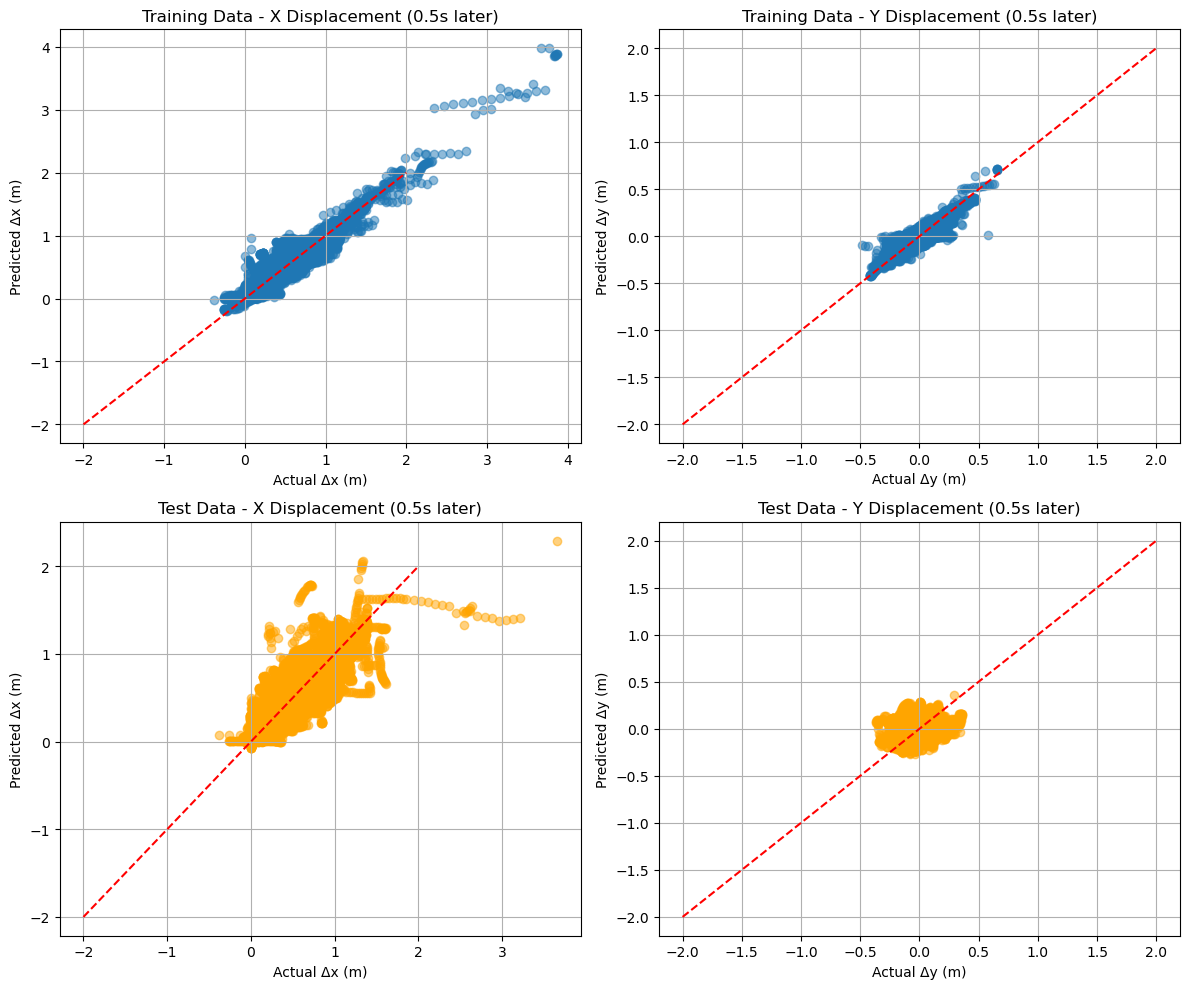

In [ ]:
def plot_pred_vs_true(y_true, y_pred, ax=None, title=""):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # データ範囲（自動）を計算
    vmin = np.nanmin([y_true.min(), y_pred.min()])
    vmax = np.nanmax([y_true.max(), y_pred.max()])
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = -1.0, 1.0  # フォールバック
    pad = max((vmax - vmin) * 0.05, 0.1)  # 5%マージン（最小0.1m）
    lo, hi = vmin - pad, vmax + pad

    # 散布図
    ax.scatter(y_true, y_pred, s=8, alpha=0.5, linewidths=0)

    # 対角線 y=x
    ax.plot([lo, hi], [lo, hi], linestyle="--", label="y = x", zorder=0)

    # 軸設定：自動スケール＋1:1
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_aspect("equal", "box")

    ax.set_xlabel("正解 (m)")
    ax.set_ylabel("予測 (m)")
    if title:
        ax.set_title(title)
    ax.grid(True, linewidth=0.4, alpha=0.4)
    ax.legend(frameon=False, loc="best")

# 使い方（Δx, Δy の2枚並べ）
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plot_pred_vs_true(y_test[:, 0], y_pred[:, 0], ax=axes[0], title="Δx (m) @ +0.5s")
plot_pred_vs_true(y_test[:, 1], y_pred[:, 1], ax=axes[1], title="Δy (m) @ +0.5s")
plt.show()

## 6. 特徴量重要度分析

=== Feature Importance ===
                       feature  importance
0                   self_speed    0.210698
4               neighbor_1_dvy    0.124012
3               neighbor_1_dvx    0.119377
33              self_past_2s_y    0.116129
8               neighbor_2_dvx    0.113408
..                         ...         ...
45      neighbor_4_past_0p5s_y    0.044417
47      neighbor_5_past_0p5s_x    0.043254
64    neighbor_5_past_1s_valid    0.043118
46  neighbor_4_past_0p5s_valid    0.042735
63        neighbor_5_past_1s_y    0.042164

[80 rows x 2 columns]


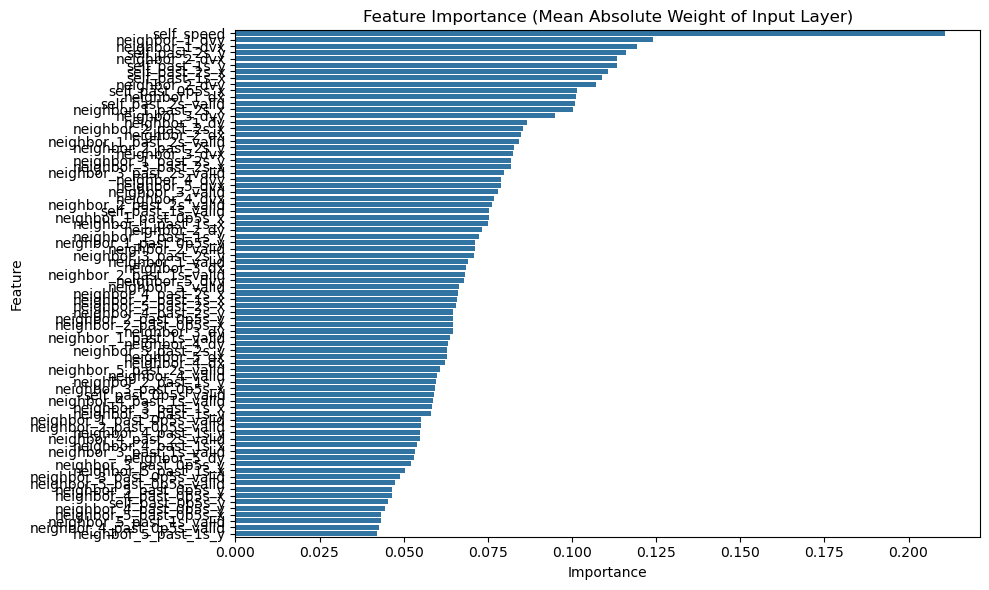

In [11]:
# 特徴量名の定義（拡張版：既存26 + 自己過去9 + 近傍過去45 = 合計80想定）
feature_names = ['self_speed']

# 既存：近傍K人の (dx, dy, dvx, dvy, valid) ＝ 5要素 × MAX_NEIGHBORS
for i in range(MAX_NEIGHBORS):
    feature_names.extend([
        f'neighbor_{i+1}_dx',
        f'neighbor_{i+1}_dy',
        f'neighbor_{i+1}_dvx',
        f'neighbor_{i+1}_dvy',
        f'neighbor_{i+1}_valid'
    ])

# 過去時点のタグ（0.5秒, 1秒, 2秒）
PAST_TAGS = ['0p5s', '1s', '2s']

# 自分の過去：各時点で (x, y, valid) ＝ 3要素 × 3時点 = 9
for tag in PAST_TAGS:
    feature_names.extend([
        f'self_past_{tag}_x',
        f'self_past_{tag}_y',
        f'self_past_{tag}_valid'
    ])

# 近傍5人の過去：各時点で 5人 × (x, y, valid) ＝ 15要素 × 3時点 = 45
for tag in PAST_TAGS:
    for i in range(MAX_NEIGHBORS):
        feature_names.extend([
            f'neighbor_{i+1}_past_{tag}_x',
            f'neighbor_{i+1}_past_{tag}_y',
            f'neighbor_{i+1}_past_{tag}_valid'
        ])

# 入力層の重み分析（簡易的な重要度）
input_weights = np.abs(mlp.coefs_[0]).mean(axis=1)

# 安全確認：特徴量名の数と入力次元が一致するか
assert len(feature_names) == input_weights.shape[0], \
    f"feature_names({len(feature_names)}) と入力重み次元({input_weights.shape[0]})が一致しません。"

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': input_weights
}).sort_values('importance', ascending=False)

print("=== Feature Importance ===")
print(importance_df)

# 重要度の可視化（全特徴を表示）
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance (Mean Absolute Weight of Input Layer)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## 7. 予測例とシミュレーション応用

In [12]:
def predict_future_position(model, scaler, current_state):
    """30フレーム後位置予測関数"""
    # 特徴量正規化
    current_state_scaled = scaler.transform([current_state])
    
    # 予測実行
    delta_ego = model.predict(current_state_scaled)[0]
    
    return delta_ego

# 予測例
if len(X_test) > 100:
    sample_idx = 100
    sample_state = X_test[sample_idx]
    actual_delta = y_test[sample_idx]
    predicted_delta = predict_future_position(mlp, scaler, sample_state)

    print("=== 予測例 ===")
    print(f"入力特徴量（最初の6要素）: {sample_state[:6]}")
    print(f"実際の{PREDICTION_TIME:.1f}秒後変位: Δx={actual_delta[0]:.4f}m, Δy={actual_delta[1]:.4f}m")
    print(f"予測{PREDICTION_TIME:.1f}秒後変位: Δx={predicted_delta[0]:.4f}m, Δy={predicted_delta[1]:.4f}m")
    print(f"誤差: {np.linalg.norm(actual_delta - predicted_delta):.4f}m")
    print(f"実際の移動距離: {np.linalg.norm(actual_delta):.4f}m")
    print(f"予測移動距離: {np.linalg.norm(predicted_delta):.4f}m")
else:
    print("テストデータが不足しています")

=== 予測例 ===
入力特徴量（最初の6要素）: [ 0.9559396   1.57195444  2.61606511 -1.34022344  0.06032252  1.        ]
実際の0.5秒後変位: Δx=0.6068m, Δy=-0.0016m
予測0.5秒後変位: Δx=0.2912m, Δy=-0.0032m
誤差: 0.3156m
実際の移動距離: 0.6068m
予測移動距離: 0.2912m


In [13]:
# モデル保存
import joblib

# モデルとスケーラーを保存
joblib.dump(mlp, 'pedestrian_avoidance_mlp_30frames.pkl')
joblib.dump(scaler, 'feature_scaler_30frames.pkl')

# パラメータも保存
params = {
    'FPS': FPS,
    'FRAME_INTERVAL': FRAME_INTERVAL,
    'PREDICTION_TIME': PREDICTION_TIME,
    'MAX_NEIGHBORS': MAX_NEIGHBORS,
    'SEARCH_RADIUS': SEARCH_RADIUS,
    'feature_names': feature_names
}
joblib.dump(params, 'model_parameters.pkl')

print("モデルを保存しました:")
print("- pedestrian_avoidance_mlp_30frames.pkl")
print("- feature_scaler_30frames.pkl")
print("- model_parameters.pkl")

モデルを保存しました:
- pedestrian_avoidance_mlp_30frames.pkl
- feature_scaler_30frames.pkl
- model_parameters.pkl


## 8. データ保存

In [14]:
# === 成果物の保存（再開を高速化） ===
from pathlib import Path
import json, time, numpy as np, pandas as pd
import joblib, sklearn, sys, platform

# 保存先ディレクトリ（タイムスタンプで新規作成）
RUN_DIR = Path("./artifacts") / time.strftime("run_%Y%m%d_%H%M%S")
RUN_DIR.mkdir(parents=True, exist_ok=True)

# 1) 教師データ（全体）
np.savez_compressed(RUN_DIR / "train_data_all.npz", X=X, y=y, uids=uids)

# 2) 分割済みデータ（ある場合は保存）
# すでに X_train_scaled / X_test_scaled, y_train, y_test がある前提。無ければ try/except 可。
try:
    np.savez_compressed(RUN_DIR / "train_split_scaled.npz",
                        X_train=X_train_scaled, X_test=X_test_scaled,
                        y_train=y_train, y_test=y_test)
except NameError:
    # スケーリング前の分割変数があればそれを保存
    try:
        np.savez_compressed(RUN_DIR / "train_split_raw.npz",
                            X_train=X_train, X_test=X_test,
                            y_train=y_train, y_test=y_test)
    except NameError:
        pass  # 分割を保存できないときはスキップ（次回は再分割）

# 3) スケーラ（学習データでfit済みのもの）
try:
    joblib.dump(scaler, RUN_DIR / "scaler.pkl")
except NameError:
    pass

# 4) 特徴量名（80個）
try:
    with open(RUN_DIR / "feature_names.json", "w", encoding="utf-8") as f:
        json.dump(feature_names, f, ensure_ascii=False, indent=2)
except NameError:
    pass

# 5) 現行の MLP モデル（参考：あとで比較したい場合）
try:
    joblib.dump(mlp, RUN_DIR / "mlp_model.pkl")
except NameError:
    pass

# 6) 重要度テーブル（あれば保存）
try:
    importance_df.to_csv(RUN_DIR / "feature_importance.csv", index=False)
except NameError:
    pass

# 7) 前処理済みデータフレーム（必要なら）
try:
    processed_data.to_parquet(RUN_DIR / "processed_data.parquet", index=False)
except NameError:
    pass

# 8) 実験のメタデータ（再現性向上）
meta = {
    "FRAME_INTERVAL": int(FRAME_INTERVAL),
    "MAX_NEIGHBORS": int(MAX_NEIGHBORS),
    "SEARCH_RADIUS": float(SEARCH_RADIUS),
    "added_history": ["0.5s", "1s", "2s"],
    "X_shape": tuple(X.shape),
    "y_shape": tuple(y.shape),
    "python": sys.version,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "sklearn": sklearn.__version__,
    "platform": platform.platform(),
}
# 可能なら評価指標も記録
for name in ["train_mse","test_mse","train_r2","test_r2","train_rmse","test_rmse"]:
    if name in globals():
        meta[name] = float(globals()[name])
with open(RUN_DIR / "meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(f"保存完了: {RUN_DIR.resolve()}")


保存完了: /mnt/f/grad_thesis/tracking/st_nn11/artifacts/run_20250806_211355


## まとめ

### 実装内容
1. **30フレーム間隔予測**: 0.5秒後の位置を予測（回避行動が観測可能な時間間隔）
2. **データ前処理**: 移動平均済みの軌跡データから30フレーム間隔での速度・ヘディング計算
3. **特徴量作成**: KD-treeによる近傍探索と自己座標系変換
4. **MLPモデル**: 26次元入力→2次元出力の回帰モデル
5. **評価**: MSE、R²スコア、可視化による性能評価

### 30フレーム間隔の利点
- **回避行動の観測**: 0.5秒間隔で歩行者の回避行動が明確に現れる
- **実用的な予測時間**: シミュレーションでの意思決定に適した時間スケール
- **ノイズ軽減**: 短時間の微小な動きによるノイズを軽減
- **計算効率**: データ量を適切に削減しつつ重要な情報を保持

### 群集シミュレーションへの応用
- 0.5秒先の位置予測により自然な回避行動を再現
- リアルタイム予測が可能な軽量モデル
- 固定長入力により実装が簡単
- validフラグで人数変動に対応
- 自己座標系により回転不変性を実現

### 今後の改善点
- 異なる時間間隔（15フレーム、45フレーム等）での比較検証
- より複雑なネットワーク構造の検討
- 実際のシミュレーション環境での検証
- 群集密度による性能変化の分析